In [3]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet 
from sklearn.model_selection import train_test_split, cross_val_score,GridSearchCV
from sklearn.metrics import r2_score
import plotnine as pt

In [4]:
# Read the data

ames = pd.read_csv("/Users/williamkapner/Documents/GSB_544/Data/AmesHousing.csv")

# Get rid of columns with mostly NaN values
good_cols = ames.isna().sum() < 100
ames = ames.loc[:,good_cols]

# Drop other NAs
ames = ames.dropna()
ames.head()

,Order,PID,MS SubClass,MS Zoning,Lot Area,Street,Lot Shape,Land Contour,Utilities,Lot Config,...,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,31770,Pave,IR1,Lvl,AllPub,Corner,...,0,0,0,0,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,11622,Pave,Reg,Lvl,AllPub,Inside,...,0,0,120,0,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,14267,Pave,IR1,Lvl,AllPub,Corner,...,0,0,0,0,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,11160,Pave,Reg,Lvl,AllPub,Corner,...,0,0,0,0,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,13830,Pave,IR1,Lvl,AllPub,Inside,...,0,0,0,0,0,3,2010,WD,Normal,189900


In [5]:
#Setting X Variables and conducting a test train split
X = ames.drop(["SalePrice", "Order", "PID"], axis = 1)
y = ames["SalePrice"]

#X_train, X_test, y_train, y_test = train_test_split(X, y)

In [6]:
ct = ColumnTransformer(
  [
    ("dummify", 
    OneHotEncoder(sparse_output = False, handle_unknown='ignore'),
    make_column_selector(dtype_include=object)),
    ("standardize", 
    StandardScaler(), 
    make_column_selector(dtype_include=np.number))
  ],
  remainder = "passthrough"
)

X_train_dummified = ct.fit_transform(X)
pd.DataFrame(X_train_dummified)


lr_pipeline_1 = Pipeline(
  [("preprocessing", ct),
  ("linear_regression", LinearRegression())]
)

ridge_pipeline = Pipeline(
    [
        ("preprocessing", ct),
        ("ridge_regression", Ridge(alpha=1.0))
    ]
)

ridge_cv_scores = cross_val_score(ridge_pipeline, X, y, cv=5, scoring='neg_mean_squared_error')
linear_cv_scores = cross_val_score(lr_pipeline_1, X, y, cv=5, scoring='neg_mean_squared_error')


print("Ridge Regression MSE:", -ridge_cv_scores.mean())
print("Linear Regression MSE:", -linear_cv_scores.mean())




Ridge Regression MSE: 878606253.136419
Linear Regression MSE: 5.910012177637989e+31


In [7]:

ridge_pipeline.fit(X, y)
lr_pipeline_1.fit(X, y)

ridge_coefficients = ridge_pipeline.named_steps["ridge_regression"].coef_
linear_coefficients = lr_pipeline_1.named_steps["linear_regression"].coef_

all_feature_names = ct.get_feature_names_out()

df = pd.DataFrame({
    "Feature": all_feature_names,
    "Ridge": ridge_coefficients,
    "Linear": linear_coefficients
})
df['diff'] = df['Ridge'] - df['Linear']

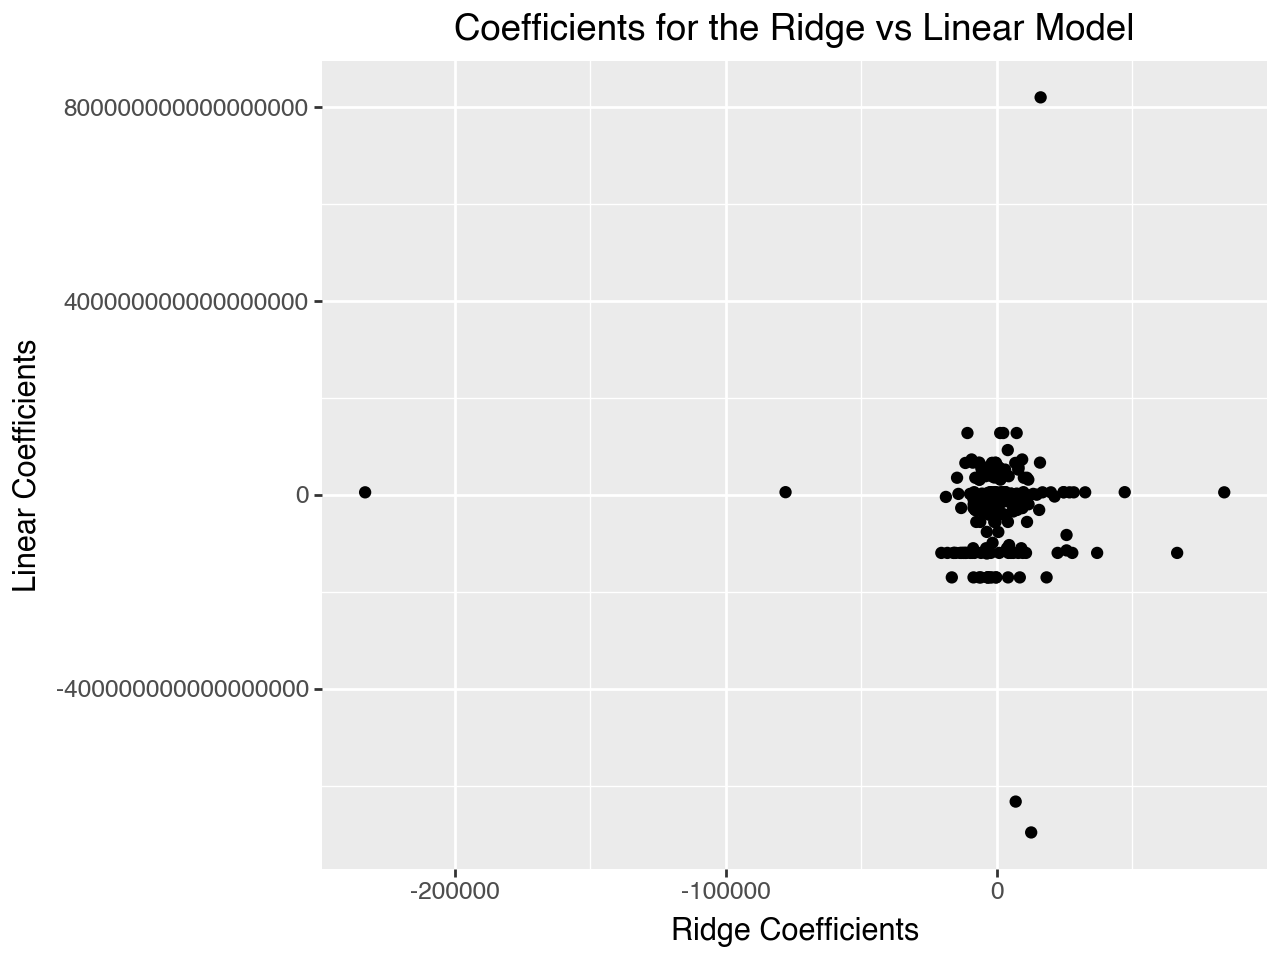

In [8]:
(pt.ggplot(df, pt.aes(x ='Ridge', y='Linear'))
 + pt.geom_point()
 + pt.labs(title = "Coefficients for the Ridge vs Linear Model",
           x= "Ridge Coefficients",
           y= 'Linear Coefficients'))

From the plot, we can see a vast majority of the coefficients for the the ridge vs linear model are very close to the same. However, there are a handful that differ by an extremely large margin, giving us extremely different models. From the pipeline models, we can see that the MSE of the Ridge Model is smaller than the MSE of the Linear Model, so the ridge model is a better predictor for this dataset.

In [9]:
param_grid = {
    "ridge_regression__alpha": [0.001, 0.01, 0.1, 1, 10, 100, 1000]
}

grid_search = GridSearchCV(
    estimator=ridge_pipeline,
    param_grid=param_grid,
    scoring="neg_mean_squared_error",
    cv=5,
    verbose=1
)

grid_search.fit(X, y)

pd.DataFrame(grid_search.cv_results_)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_ridge_regression__alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.024449,0.003205,0.005935,0.001618,0.001,{'ridge_regression__alpha': 0.001},-7.879837e+08,-5.055365e+08,-1.232594e+09,-1.558419e+09,-5.521019e+08,-9.273271e+08,4.073286e+08,6
1,0.020263,0.003662,0.005320,0.001135,0.01,{'ridge_regression__alpha': 0.01},-7.875414e+08,-5.043629e+08,-1.231952e+09,-1.555683e+09,-5.490131e+08,-9.257105e+08,4.072283e+08,5
2,0.018569,0.005617,0.007978,0.003130,0.1,{'ridge_regression__alpha': 0.1},-7.844687e+08,-4.948191e+08,-1.226204e+09,-1.533577e+09,-5.252551e+08,-9.128649e+08,4.061908e+08,4
3,0.024728,0.006301,0.005886,0.002170,1,{'ridge_regression__alpha': 1},-7.812889e+08,-4.658465e+08,-1.198009e+09,-1.468869e+09,-4.790183e+08,-8.786063e+08,3.974769e+08,2
4,0.019261,0.003941,0.005463,0.002828,10,{'ridge_regression__alpha': 10},-7.843267e+08,-4.468206e+08,-1.165080e+09,-1.455916e+09,-4.723607e+08,-8.649009e+08,3.936439e+08,1
5,0.020099,0.004816,0.005289,0.002330,100,{'ridge_regression__alpha': 100},-8.610209e+08,-4.402347e+08,-1.206868e+09,-1.558299e+09,-4.809330e+08,-9.094712e+08,4.279248e+08,3
6,0.027624,0.004189,0.007180,0.001743,1000,{'ridge_regression__alpha': 1000},-1.134543e+09,-5.779050e+08,-1.264095e+09,-1.725513e+09,-6.446800e+08,-1.069347e+09,4.229867e+08,7


According to the table, the best alpha value to use of 10. This is the model wehre we have the lowest MSE, so it is our most optimal ridge alpha value.

In [ ]:
lasso_pipeline = Pipeline(
    [
        ("preprocessing", ct),  
        ("lasso_regression", Lasso())
    ]
)

param_grid = {
    "lasso_regression__alpha": [0.01, 0.1, 1, 10, 100]  # Lasso alpha values to tune
}

# Set up GridSearchCV with cross-validation and scoring as negative mean squared error
grid_search_lasso = GridSearchCV(
    estimator=lasso_pipeline,
    param_grid=param_grid,
    scoring="neg_mean_squared_error",
    cv=5,
    verbose=1
)

# Fit the GridSearchCV
grid_search_lasso.fit(X, y)

pd.DataFrame(grid_search_lasso.cv_results_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.109e+11, tolerance: 1.348e+09
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.466e+11, tolerance: 1.474e+09
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.894e+11, tolerance: 1.463e+09
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coor

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_lasso_regression__alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.626347,0.015942,0.010869,0.002212,0.001,{'lasso_regression__alpha': 0.001},-7.886243e+08,-5.055950e+08,-1.224976e+09,-1.545503e+09,-5.254262e+08,-9.180250e+08,4.071670e+08,6
1,0.635158,0.044904,0.010784,0.000363,0.01,{'lasso_regression__alpha': 0.01},-7.885959e+08,-5.055637e+08,-1.221825e+09,-1.545230e+09,-5.257282e+08,-9.173885e+08,4.065590e+08,5
2,0.589330,0.076159,0.008366,0.002313,0.1,{'lasso_regression__alpha': 0.1},-7.881923e+08,-5.052834e+08,-1.192081e+09,-1.545152e+09,-5.265207e+08,-9.114459e+08,4.021607e+08,4
3,0.617355,0.304723,0.007334,0.001391,1,{'lasso_regression__alpha': 1},-7.844667e+08,-5.025365e+08,-1.186430e+09,-1.543847e+09,-5.235216e+08,-9.081603e+08,4.023206e+08,3
4,0.188393,0.078914,0.008275,0.003453,10,{'lasso_regression__alpha': 10},-7.612077e+08,-4.792376e+08,-1.160131e+09,-1.527524e+09,-5.048793e+08,-8.865960e+08,4.032322e+08,2
5,0.165920,0.014420,0.005212,0.001863,100,{'lasso_regression__alpha': 100},-7.533482e+08,-4.263880e+08,-1.136937e+09,-1.480770e+09,-4.475923e+08,-8.490071e+08,4.076566e+08,1


Here, we can see our best LASSO regression model was the last one with an alpha value of 100 and a MSE of 8.490071e+08. 

In [11]:
best_lasso_model = grid_search_lasso.best_estimator_


ridge_coefficients = ridge_pipeline.named_steps["ridge_regression"].coef_
linear_coefficients = lr_pipeline_1.named_steps["linear_regression"].coef_
lasso_coefficients = best_lasso_model.named_steps["lasso_regression"].coef_

all_feature_names = ct.get_feature_names_out()

df1 = pd.DataFrame({
    "Feature": all_feature_names,
    "Ridge": ridge_coefficients,
    "Linear": linear_coefficients,
    "Lasso": lasso_coefficients
})

df_melted = pd.melt(df1, id_vars=["Feature"], value_vars=["Ridge", "Lasso","Linear"], var_name="Model", value_name="Coefficient")
df_melted

,Feature,Model,Coefficient
0,dummify__MS Zoning_C (all),Ridge,-5585.147072
1,dummify__MS Zoning_FV,Ridge,1279.599730
2,dummify__MS Zoning_I (all),Ridge,-5465.717759
3,dummify__MS Zoning_RH,Ridge,7876.141644
4,dummify__MS Zoning_RL,Ridge,3046.095382
...,...,...,...
757,standardize__Screen Porch,Linear,2556.000000
758,standardize__Pool Area,Linear,2752.000000
759,standardize__Misc Val,Linear,-5224.000000
760,standardize__Mo Sold,Linear,-736.000000


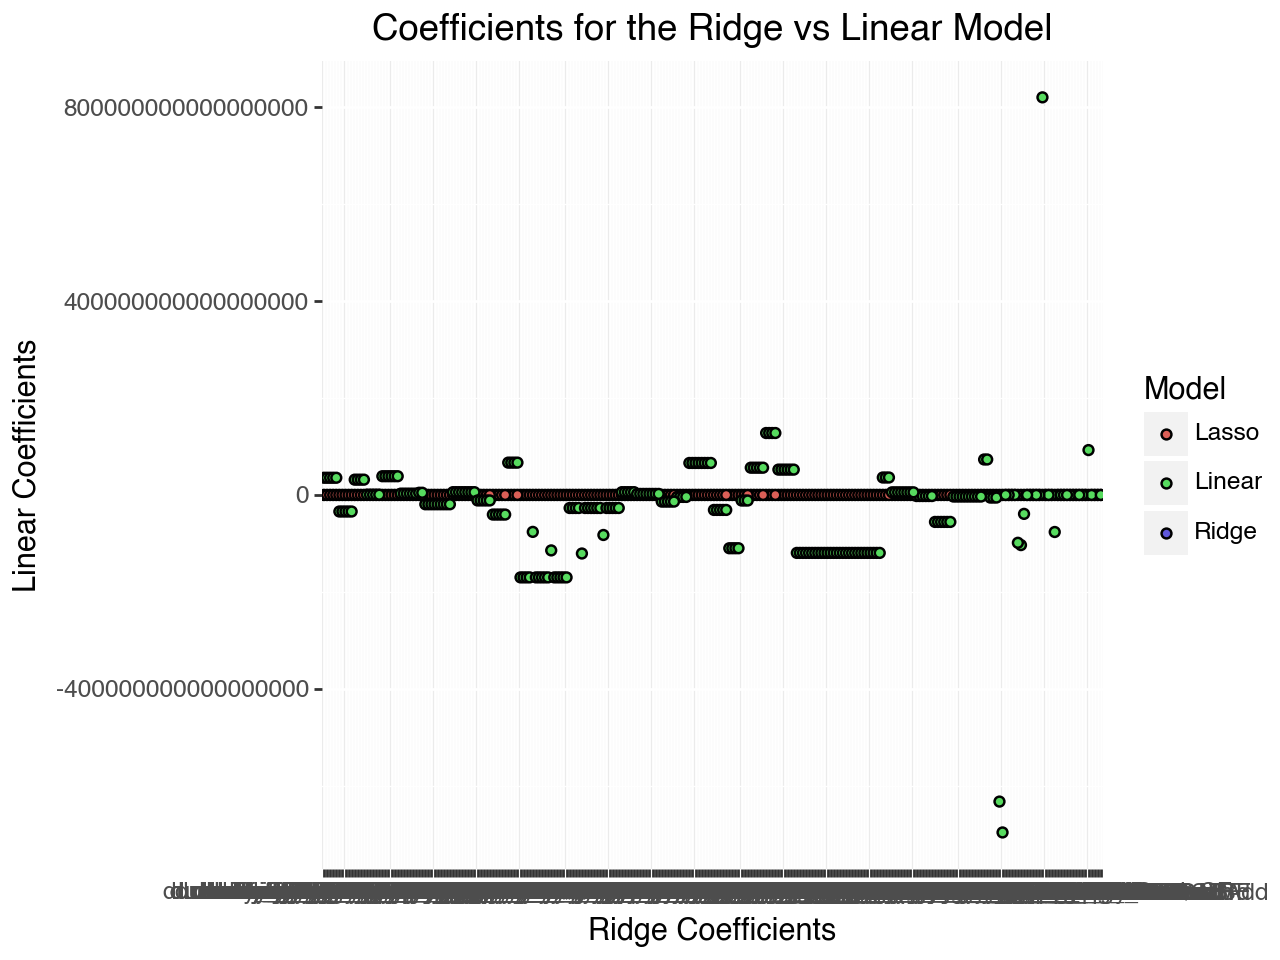

In [12]:
(pt.ggplot(df_melted, pt.aes(x ='Feature', y='Coefficient', fill = "Model"))
 + pt.geom_point()
 + pt.labs(title = "Coefficients for the Ridge vs Linear Model",
           x= "Ridge Coefficients",
           y= 'Linear Coefficients'))

This is difficult to visualize due to how many coefficients there are, but we can notice that the Lasso and Ridge models have smaller coefficients, while the Linear model has many extreme values. This could be a case where using one of the adjusted models is useful to eliminate these outlier coefficients.  
Lasso: 8.490071e+08
Ridge: 8.649009e+08
Linear: 5.910012177637989e+31

According to the above MSE values, the Ridge and Lasso models are far better with predictions than the Linear Model, and the Lasso model is the best so far.

In [ ]:
elastic_net_pipeline = Pipeline(
    [
        ("preprocessing", ct),
        ("elastic_net", ElasticNet())
    ]
)


param_grid = {
    "elastic_net__alpha": [0.001, 0.01, 0.1, 1, 10, 100], 
    "elastic_net__l1_ratio": [0.1, 0.3, 0.5, 0.7, 0.9]  
}

# Set up GridSearchCV with cross-validation
grid_search_elastic_net = GridSearchCV(
    estimator=elastic_net_pipeline,
    param_grid=param_grid,
    scoring="neg_mean_squared_error",
    cv=5, 
    verbose=1
)

# Fit the model
grid_search_elastic_net.fit(X, y)

pd.DataFrame(grid_search_elastic_net.cv_results_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_elastic_net__alpha,param_elastic_net__l1_ratio,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.109683,0.013028,0.006917,0.002915,0.1,0.1,"{'elastic_net__alpha': 0.1, 'elastic_net__l1_ratio': 0.1}",-9.125046e+08,-4.592055e+08,-1.229129e+09,-1.608471e+09,-5.084832e+08,-9.435588e+08,4.355485e+08,5
1,0.104896,0.017009,0.008270,0.002875,0.1,0.3,"{'elastic_net__alpha': 0.1, 'elastic_net__l1_ratio': 0.3}",-8.922896e+08,-4.506398e+08,-1.221718e+09,-1.590417e+09,-4.968898e+08,-9.303909e+08,4.335994e+08,4
2,0.114451,0.014501,0.009088,0.003217,0.1,0.5,"{'elastic_net__alpha': 0.1, 'elastic_net__l1_ratio': 0.5}",-8.686595e+08,-4.423848e+08,-1.210898e+09,-1.566644e+09,-4.845289e+08,-9.146230e+08,4.296539e+08,3
3,0.152946,0.018565,0.008240,0.002907,0.1,0.7,"{'elastic_net__alpha': 0.1, 'elastic_net__l1_ratio': 0.7}",-8.390124e+08,-4.358939e+08,-1.194073e+09,-1.532621e+09,-4.722213e+08,-8.947642e+08,4.215825e+08,2
4,0.326479,0.039470,0.006749,0.002506,0.1,0.9,"{'elastic_net__alpha': 0.1, 'elastic_net__l1_ratio': 0.9}",-7.975570e+08,-4.387697e+08,-1.168181e+09,-1.476925e+09,-4.669315e+08,-8.696729e+08,4.027261e+08,1
5,0.046113,0.004563,0.006040,0.001399,1,0.1,"{'elastic_net__alpha': 1, 'elastic_net__l1_ratio': 0.1}",-1.343826e+09,-6.910579e+08,-1.301286e+09,-1.800060e+09,-7.668437e+08,-1.180615e+09,4.088482e+08,10
6,0.050987,0.011109,0.007765,0.002545,1,0.3,"{'elastic_net__alpha': 1, 'elastic_net__l1_ratio': 0.3}",-1.256190e+09,-6.438538e+08,-1.283199e+09,-1.768839e+09,-7.164394e+08,-1.133704e+09,4.134758e+08,9
7,0.063086,0.013673,0.015293,0.012453,1,0.5,"{'elastic_net__alpha': 1, 'elastic_net__l1_ratio': 0.5}",-1.162754e+09,-5.933352e+08,-1.267975e+09,-1.735895e+09,-6.615972e+08,-1.084311e+09,4.205216e+08,8
8,0.068347,0.012583,0.012586,0.004332,1,0.7,"{'elastic_net__alpha': 1, 'elastic_net__l1_ratio': 0.7}",-1.058308e+09,-5.360805e+08,-1.255007e+09,-1.695260e+09,-5.983941e+08,-1.028610e+09,4.299375e+08,7
9,0.073472,0.009712,0.007613,0.003493,1,0.9,"{'elastic_net__alpha': 1, 'elastic_net__l1_ratio': 0.9}",-9.218997e+08,-4.635304e+08,-1.232160e+09,-1.616165e+09,-5.140285e+08,-9.495568e+08,4.360969e+08,6


In [ ]:
results = pd.DataFrame(grid_search_elastic_net.cv_results_)
results.iloc[7][["params", "mean_test_score"]]
pd.set_option("display.max_colwidth", None) 
pd.set_option("display.max_rows", None)  
pd.set_option("display.max_columns", None) 
print(results.iloc[7][["params", "mean_test_score"]])

params             {'elastic_net__alpha': 1, 'elastic_net__l1_ratio': 0.5}
mean_test_score                                         -1084311357.789254
Name: 7, dtype: object


The ideal alpha value was 1 and the ideal L1 ratio was 0.5 for the Elastic model. The MSE for this model was 1,084,311,357. This means this was not the best model and still falls short of the LASSO model. This model seems to be a combination of the Ridge and LASSO models, but in this case, the LASSO makes more accurate predictions.

Chat GPT-4o was used to automate some regression and help with syntax error codes.